# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise
from audiomentations import Normalize
# from audiomentations import BandPassFilter, Gain, HighPassFilter

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v3','train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v3', 'audio_model')
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

np.random.seed(0)

In [3]:
# classes = ('Defect-free', 'Defective', 'Laser-off')
classes = ('Defect-free', 'Keyhole pores', 'Laser defocus', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100

### Use GPU if possible

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


In [16]:
torch.manual_seed(0)

### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [5]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name_v3'])

df_multimodal

sample index  Time_Stamps      audio_file_name      image_file_name  \
0                 1         0.00      sample_21_1.wav      sample_21_1.jpg   
1                 2         0.04      sample_21_2.wav      sample_21_2.jpg   
2                 3         0.08      sample_21_3.wav      sample_21_3.jpg   
3                 4         0.12      sample_21_4.wav      sample_21_4.jpg   
4                 5         0.16      sample_21_5.wav      sample_21_5.jpg   
...             ...          ...                  ...                  ...   
48461         10982       439.24  sample_26_10982.wav  sample_26_10982.jpg   
48462         10983       439.28  sample_26_10983.wav  sample_26_10983.jpg   
48463         10984       439.32  sample_26_10984.wav  sample_26_10984.jpg   
48464         10985       439.36  sample_26_10985.wav  sample_26_10985.jpg   
48465         10986       439.40  sample_26_10986.wav  sample_26_10986.jpg   

        class_name class_name_v2  Layer number  Sample number class_name_v3  \
0        Laser-off     Laser-off           1.0             21     Laser-off   
1      Defect-free   Defect-free           1.0             21   Defect-free   
2      Defect-free   Defect-free           1.0             21   Defect-free   
3      Defect-free   Defect-free           1.0             21   Defect-free   
4      Defect-free   Defect-free           1.0             21   Defect-free   
...            ...           ...           ...            ...           ...   
48461    Laser-off     Laser-off           NaN             26     Laser-off   
48462    Laser-off     Laser-off           NaN             26     Laser-off   
48463    Laser-off     Laser-off           NaN             26     Laser-off   
48464    Laser-off     Laser-off           NaN             26     Laser-off   
48465    Laser-off     Laser-off           NaN             26     Laser-off   

       rms_energy  ...    center_y  contour_area  contour_length      X  \
0        0.009018  ...    0.000000           0.0        0.000000  0.000   
1        0.019286  ...  239.000000      305442.0     2234.000000  0.000   
2        0.019593  ...  239.000000      305442.0     2234.000000 -0.010   
3        0.030937  ...  230.264496      291865.5     2279.781744 -0.007   
4        0.038329  ...  229.109962      281970.0     2407.847760 -0.111   
...           ...  ...         ...           ...             ...    ...   
48461    0.011000  ...    0.000000           0.0        0.000000  0.000   
48462    0.008347  ...    0.000000           0.0        0.000000  0.000   
48463    0.011081  ...    0.000000           0.0        0.000000  0.000   
48464    0.011044  ...    0.000000           0.0        0.000000  0.000   
48465    0.013110  ...    0.000000           0.0        0.000000  0.000   

           Y      Z     Vx     Vy     Vz  Speed  
0      0.000  0.000  0.000 -0.000  0.000  0.000  
1     -0.000  0.001 -0.074 -0.074  0.000  0.105  
2      0.015 -0.007 -0.051  0.026 -0.051  0.077  
3      0.016  0.010  0.173 -0.222  2.520  2.536  
4      0.123 -0.057 -1.864  1.662 -2.468  3.511  
...      ...    ...    ...    ...    ...    ...  
48461  0.000  0.000 -0.076  0.025  0.000  0.080  
48462  0.000  0.000 -0.076  0.025  0.000  0.080  
48463  0.000  0.000 -0.076  0.025  0.000  0.080  
48464  0.000  0.000 -0.076  0.025  0.000  0.080  
48465  0.000  0.000 -0.076  0.025  0.000  0.080  

[36557 rows x 135 columns]

In [6]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v3'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 7601  4991  6208 17757]


In [7]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v3')["class_name_v3"].count()/df_multimodal.shape[0]*100, 1)

class_name_v3
Defect-free      20.8
Keyhole pores    13.7
Laser defocus    17.0
Laser-off        48.6
Name: class_name_v3, dtype: float64

Saving figure dataset_distribution.png


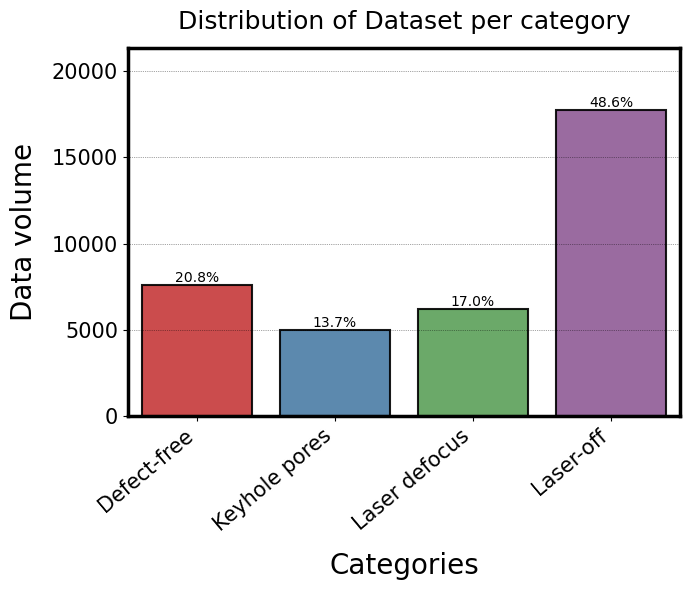

In [9]:
filename = 'dataset_distribution'
plot_data_distribution(df_multimodal, 'class_name_v3', 
                       'Distribution of Dataset per category', filename)
save_fig(f"{filename}.png")

## Preparing Dataset and DataLoader

#### Data Augmentation methods

In [10]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

# MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



# augmentation = Compose(
#     [
#        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),
#        # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
#        BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
#        # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
#        Normalize(p=0.5)
#     ]
# )


# # Initialize augmentation callable
# apply_augmentation = Compose(
#     transforms=[
#         # Gain(
#         #     min_gain_in_db=-15.0,
#         #     max_gain_in_db=5.0,
#         #     p=0.5,
#         # ),
#         PolarityInversion(p=0.5)
#     ]
# )

# train_transform = transforms.Compose([
#     augmentation,
#     apply_augmentation,
#     # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
#     # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
#     torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
# ])


In [11]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(df_multimodal,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:36557


## Train Val Test dataset 

In [12]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [13]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = LDEDAudioDataset(train_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
val_dataset = LDEDAudioDataset(val_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
test_dataset = LDEDAudioDataset(test_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)

### Create DataLoader using the dataset

In [32]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:29245
length of the val dataset:3656
length of the test dataset:3656


### Hyperparameter tuning

In [20]:
# Importing required libraries
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


#Objective function
def objective(params):
    # Initialize your model
    net = MFCCCNN(dropout_rate=params['dropout_rate'])
    net = net.to(device)
    
    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], weight_decay=params['regularization'])
    else:
        optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['regularization'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Create DataLoaders
    BATCH_SIZE = int(params['batch_size'])
    
     # Use a subset of the dataset for hyperparameter tuning
    n_train = int(len(train_dataset) * 0.2)  # 20% of the training set
    n_val = int(len(val_dataset) * 0.1)  # 10% of the validation set
    
    subset_train_dataset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), n_train, replace=False))
    subset_val_dataset = torch.utils.data.Subset(val_dataset, np.random.choice(len(val_dataset), n_val, replace=False))
    
    train_dataloader = DataLoader(subset_train_dataset, batch_size=int(params['batch_size']), shuffle=True, num_workers=4)
    val_dataloader = DataLoader(subset_val_dataset, batch_size=int(params['batch_size']), shuffle=False, num_workers=4)
    
    # Training loop
    _, _, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(
        model=net, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        train_loader=train_dataloader, 
        valid_loader=val_dataloader, 
        epochs=5,  # adjust this
        scheduler=scheduler,
        device=device, 
        print_every=1,
        mode="single_model"
    )
    
    min_valid_loss = min(valid_losses)
    max_valid_accuracy = max(valid_accuracy)
    
    return {'loss': min_valid_loss, 'status': STATUS_OK, 'best_accuracy': max_valid_accuracy}


# Define hyperparameter space
space = {
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -7, -2),
    'momentum': hp.uniform('momentum', 0.7, 0.99),
    'regularization': hp.choice('regularization', [1e-3, 1e-4, 1e-5])
}

# Run optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

                                                                                     
Epoch: 0
  0%|                                         | 0/10 [00:00<?, ?trial/s, best loss=?]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=20.3]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.38, accuracy=20.3]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.35, accuracy=34.4]

Epoch 0:   2%|2         | 2/92 [00:07<04:49,  3.22s/it, loss=1.35, accuracy=34.4]

Epoch 0:   2%|2         | 2/92 [00:07<04:49,  3.22s/it, loss=1.31, accuracy=39.6]

Epoch 0:   3%|3         | 3/92 [00:07<02:42,  1.83s/it, loss=1.31, accuracy=39.6]

Epoch 0:   3%|3         | 3/92 [00:09<02:42,  1.83s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.29, accuracy=43.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.28, accuracy=44.5]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.26, accuracy=47.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  

17:53:48 --- Epoch: 0	Train loss: 1.2683	Valid loss: 0.0205	Train accuracy: 47.43	Valid accuracy: 49.59
                                                                                     
Epoch: 1
  0%|                                         | 0/10 [00:19<?, ?trial/s, best loss=?]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.21, accuracy=53.1]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.24, accuracy=50.8]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.27, accuracy=47.4]

Epoch 1:   3%|3         | 3/92 [00:07<03:03,  2.06s/it, loss=1.27, accuracy=47.4]

Epoch 1:   3%|3         | 3/92 [00:09<03:03,  2.06s/it, loss=1.27, accuracy=47.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.27, accuracy=47.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.26, accuracy=48.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49]  

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49.8]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49.8]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  

17:54:08 --- Epoch: 1	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 2
  0%|                                         | 0/10 [00:39<?, ?trial/s, best loss=?]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.4, accuracy=34.4]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.4, accuracy=34.4]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.31, accuracy=43.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.26, accuracy=47.9]

Epoch 2:   1%|1         | 1/92 [00:08<11:18,  7.45s/it, loss=1.29, accuracy=45.7]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.29, accuracy=45.7]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.28, accuracy=46.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.26, accuracy=48.2]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.

17:54:27 --- Epoch: 2	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 3
  0%|                                         | 0/10 [00:58<?, ?trial/s, best loss=?]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.31, accuracy=43.2]

Epoch 3:   3%|3         | 3/92 [00:07<03:04,  2.07s/it, loss=1.31, accuracy=43.2]

Epoch 3:   3%|3         | 3/92 [00:09<03:04,  2.07s/it, loss=1.31, accuracy=43]  

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.31, accuracy=43]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.31, accuracy=43.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.1] 

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77

17:54:47 --- Epoch: 3	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 4
  0%|                                         | 0/10 [01:18<?, ?trial/s, best loss=?]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.32, accuracy=42.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.32, accuracy=42.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.31, accuracy=43.8]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.3, accuracy=44.8] 

Epoch 4:   1%|1         | 1/92 [00:08<11:06,  7.33s/it, loss=1.28, accuracy=46.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.28, accuracy=46.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.3]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.28, accuracy=46.4]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.3, accuracy=44.5] 

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.3]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  

17:55:06 --- Epoch: 4	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 0
 10%|█▍            | 1/10 [01:37<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|1         | 3/183 [00:07<06:06,  2.04s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|1         | 3/183 [00:08<06:06,  2.04s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=15]  

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=16.1]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=18.4]

Epoch 0:   2%|2         | 4/183 [0

17:55:25 --- Epoch: 0	Train loss: 1.2640	Valid loss: 0.0409	Train accuracy: 47.87	Valid accuracy: 49.86
                                                                                     
Epoch: 1
 10%|█▍            | 1/10 [01:56<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.15, accuracy=59.4]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.18, accuracy=56.2]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.2, accuracy=54.2] 

Epoch 1:   2%|1         | 3/183 [00:07<06:17,  2.10s/it, loss=1.2, accuracy=54.2]

Epoch 1:   2%|1         | 3/183 [00:09<06:17,  2.10s/it, loss=1.2, accuracy=53.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.2, accuracy=53.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.8]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.22, accuracy=52.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.1]

Epoch 1:   2%|2         | 4/183 [00:0

17:55:46 --- Epoch: 1	Train loss: 1.2537	Valid loss: 0.0409	Train accuracy: 49.00	Valid accuracy: 49.86
                                                                                     
Epoch: 2
 10%|█▍            | 1/10 [02:17<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.31, accuracy=43.8]

Epoch 2:   1%|          | 1/183 [00:07<23:38,  7.79s/it, loss=1.31, accuracy=43.8]

Epoch 2:   1%|          | 1/183 [00:07<23:38,  7.79s/it, loss=1.27, accuracy=46.9]

Epoch 2:   1%|1         | 2/183 [00:07<09:51,  3.27s/it, loss=1.27, accuracy=46.9]

Epoch 2:   1%|1         | 2/183 [00:07<09:51,  3.27s/it, loss=1.25, accuracy=49]  

Epoch 2:   1%|1         | 2/183 [00:09<09:51,  3.27s/it, loss=1.25, accuracy=49.2]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.25, accuracy=49.2]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.27, accuracy=46.9]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.29, accuracy=45.8]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.3, accuracy=44.6] 

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.3, accuracy=44.1]

Epoch 2:   2%|2         | 4/183 [00

17:56:07 --- Epoch: 2	Train loss: 1.2526	Valid loss: 0.0409	Train accuracy: 49.10	Valid accuracy: 49.86
                                                                                     
Epoch: 3
 10%|█▍            | 1/10 [02:38<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.18, accuracy=56.2]

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.2, accuracy=54.7] 

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.25, accuracy=49] 

Epoch 3:   1%|          | 1/183 [00:08<21:59,  7.25s/it, loss=1.25, accuracy=49.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.25, accuracy=49.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=48.1]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.27, accuracy=47.3]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=48]  

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=47.9]

Epoch 3:   2%|2         | 4/183 [00

17:56:26 --- Epoch: 3	Train loss: 1.2533	Valid loss: 0.0409	Train accuracy: 49.03	Valid accuracy: 49.86
                                                                                     
Epoch: 4
 10%|█▍            | 1/10 [02:58<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:23,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:23,  7.38s/it, loss=1.2, accuracy=54.7] 

Epoch 4:   1%|1         | 2/183 [00:07<09:21,  3.10s/it, loss=1.2, accuracy=54.7]

Epoch 4:   1%|1         | 2/183 [00:07<09:21,  3.10s/it, loss=1.2, accuracy=54.2]

Epoch 4:   1%|1         | 2/183 [00:09<09:21,  3.10s/it, loss=1.17, accuracy=57.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.17, accuracy=57.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.16, accuracy=58.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.16, accuracy=58.9]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.18, accuracy=56.7]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.19, accuracy=55.5]

Epoch 4:   2%|2         | 4/183 [00:

17:56:47 --- Epoch: 4	Train loss: 1.2521	Valid loss: 0.0409	Train accuracy: 49.15	Valid accuracy: 49.86
                                                                                     
Epoch: 0
 20%|██▊           | 2/10 [03:18<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.38, accuracy=50]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.38, accuracy=50]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.3, accuracy=59.4]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.28, accuracy=56.2]

Epoch 0:   1%|          | 1/183 [00:09<23:42,  7.82s/it, loss=1.25, accuracy=57]  

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.25, accuracy=57]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.24, accuracy=56.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.27, accuracy=52.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50.9]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50.4]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50]  

Epoch 0:   2%|2         | 4/183 [00:09<05

17:57:08 --- Epoch: 0	Train loss: 1.2551	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 1
 20%|██▊           | 2/10 [03:39<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.34, accuracy=40.6]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.34, accuracy=40.6]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.4, accuracy=34.4] 

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.37, accuracy=37.5]

Epoch 1:   2%|1         | 3/183 [00:07<05:53,  1.96s/it, loss=1.37, accuracy=37.5]

Epoch 1:   2%|1         | 3/183 [00:09<05:53,  1.96s/it, loss=1.35, accuracy=39.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.35, accuracy=39.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.34, accuracy=40.6]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.32, accuracy=42.7]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.3, accuracy=44.6] 

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.29, accuracy=45.7]

Epoch 1:   2%|2         | 4/183 [0

17:57:28 --- Epoch: 1	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 2
 20%|██▊           | 2/10 [03:59<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.2, accuracy=54.7] 

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.18, accuracy=56.2]

Epoch 2:   2%|1         | 3/183 [00:07<05:50,  1.95s/it, loss=1.18, accuracy=56.2]

Epoch 2:   2%|1         | 3/183 [00:08<05:50,  1.95s/it, loss=1.2, accuracy=53.9] 

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.2, accuracy=53.9]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.2, accuracy=54.4]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.21, accuracy=53.6]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.22, accuracy=52.7]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.22, accuracy=52.7]

Epoch 2:   2%|2         | 4/183 [00:

17:57:49 --- Epoch: 2	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 3
 20%|██▊           | 2/10 [04:20<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.4, accuracy=34.4]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.4, accuracy=34.4]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.31, accuracy=43.8]

Epoch 3:   1%|          | 1/183 [00:08<21:58,  7.24s/it, loss=1.32, accuracy=42.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.32, accuracy=42.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.28, accuracy=46.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.24, accuracy=50]  

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.26, accuracy=48.7]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.27, accuracy=47.6]

Epoch 3:   2%|2         | 4/183 [00:

17:58:09 --- Epoch: 3	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 4
 20%|██▊           | 2/10 [04:40<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.24, accuracy=50]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.24, accuracy=50]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.23, accuracy=51.6]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.21, accuracy=53.1]

Epoch 4:   2%|1         | 3/183 [00:07<06:11,  2.06s/it, loss=1.21, accuracy=53.1]

Epoch 4:   2%|1         | 3/183 [00:09<06:11,  2.06s/it, loss=1.27, accuracy=47.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.5]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=47.9]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.3]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=48]  

Epoch 4:   2%|2         | 4/183 [00:09

17:58:30 --- Epoch: 4	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 0
 30%|███▉         | 3/10 [05:01<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=13.7]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=13.8]

Epoch 0:   2%|2         | 1/46 [00:09<05:45,  7.68s/it, loss=1.39, accuracy=15.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=15.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=18.8]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=23.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=26.3]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.38, accuracy=29.7]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.38, accuracy=31.8]

Epoch 0:  20%|#9        | 9/46 [00:09<00:23,  

17:58:49 --- Epoch: 0	Train loss: 1.2844	Valid loss: 0.0093	Train accuracy: 49.77	Valid accuracy: 59.73
                                                                                     
Epoch: 1
 30%|███▉         | 3/10 [05:20<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.1, accuracy=65.6]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.1, accuracy=65.6]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.14, accuracy=60.9]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.15, accuracy=59.6]

Epoch 1:   7%|6         | 3/46 [00:07<01:27,  2.03s/it, loss=1.15, accuracy=59.6]

Epoch 1:   7%|6         | 3/46 [00:08<01:27,  2.03s/it, loss=1.15, accuracy=59.6]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.15, accuracy=59.6]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.14, accuracy=60.3]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.14, accuracy=59.9]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.13, accuracy=60.5]

Epoch 1:   9%|8         | 4/46 [00:09<01:13,  1.74s/it, loss=1.13, accuracy=61.1]

Epoch 1:   9%|8         | 4/46 [00:09<01:13,  1.

17:59:07 --- Epoch: 1	Train loss: 1.1228	Valid loss: 0.0090	Train accuracy: 61.10	Valid accuracy: 65.21
                                                                                     
Epoch: 2
 30%|███▉         | 3/10 [05:38<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.09, accuracy=67.2]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.09, accuracy=67.2]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.07, accuracy=68.4]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.11, accuracy=62.5]

Epoch 2:   2%|2         | 1/46 [00:09<05:32,  7.38s/it, loss=1.11, accuracy=63.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.11, accuracy=63.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.12, accuracy=61.6]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.11, accuracy=62.5]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.09, accuracy=64.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.1, accuracy=63.4] 

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.1, accuracy=63.7]

Epoch 2:  20%|#9        | 9/46 [00:09<00:24,  1

17:59:25 --- Epoch: 2	Train loss: 1.0869	Valid loss: 0.0087	Train accuracy: 65.12	Valid accuracy: 66.58
                                                                                     
Epoch: 3
 30%|███▉         | 3/10 [05:56<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.05, accuracy=70.3]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.05, accuracy=70.3]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.09, accuracy=64.8]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.08, accuracy=64.8]

Epoch 3:   7%|6         | 3/46 [00:07<01:26,  2.02s/it, loss=1.08, accuracy=64.8]

Epoch 3:   7%|6         | 3/46 [00:08<01:26,  2.02s/it, loss=1.07, accuracy=66.6]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=66.6]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.9]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.8]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.08, accuracy=65.2]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.7]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  

17:59:43 --- Epoch: 3	Train loss: 1.0678	Valid loss: 0.0085	Train accuracy: 66.49	Valid accuracy: 70.14
                                                                                     
Epoch: 4
 30%|███▉         | 3/10 [06:14<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.07, accuracy=68]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.07, accuracy=68]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.03, accuracy=71.1]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.04, accuracy=70.1]

Epoch 4:   7%|6         | 3/46 [00:07<01:28,  2.06s/it, loss=1.04, accuracy=70.1]

Epoch 4:   7%|6         | 3/46 [00:08<01:28,  2.06s/it, loss=1.03, accuracy=71.1]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=71.1]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.04, accuracy=70.3]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=70.7]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=70.8]

Epoch 4:   9%|8         | 4/46 [00:09<01:14,  1.77s/it, loss=1.03, accuracy=70.8]

Epoch 4:  17%|#7        | 8/46 [00:09<00:23,  1.64

18:00:01 --- Epoch: 4	Train loss: 1.0403	Valid loss: 0.0084	Train accuracy: 69.72	Valid accuracy: 70.41
                                                                                     
Epoch: 0
 40%|█████▌        | 4/10 [06:32<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=18.8]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.39, accuracy=18.8]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.49, accuracy=17.2]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.54, accuracy=14.6]

Epoch 0:   2%|1         | 3/183 [00:07<06:04,  2.03s/it, loss=1.54, accuracy=14.6]

Epoch 0:   2%|1         | 3/183 [00:09<06:04,  2.03s/it, loss=1.56, accuracy=14.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.56, accuracy=14.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.57, accuracy=13.8]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.6, accuracy=11.5] 

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.61, accuracy=11.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.61, accuracy=10.9]

Epoch 0:   2%|2         | 4/183 [0

18:00:22 --- Epoch: 0	Train loss: 1.6065	Valid loss: 0.0539	Train accuracy: 13.63	Valid accuracy: 10.68
                                                                                     
Epoch: 1
 40%|█████▌        | 4/10 [06:53<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.65, accuracy=9.38]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.65, accuracy=9.38]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.59, accuracy=15.6]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.59, accuracy=15.6]

Epoch 1:   2%|1         | 3/183 [00:07<06:05,  2.03s/it, loss=1.59, accuracy=15.6]

Epoch 1:   2%|1         | 3/183 [00:09<06:05,  2.03s/it, loss=1.6, accuracy=14.1] 

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.6, accuracy=14.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=13.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=13]  

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=12.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.62, accuracy=12.1]

Epoch 1:   2%|2         | 4/183 [00

18:00:43 --- Epoch: 1	Train loss: 1.6072	Valid loss: 0.0539	Train accuracy: 13.64	Valid accuracy: 10.68
                                                                                     
Epoch: 2
 40%|█████▌        | 4/10 [07:14<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.68, accuracy=6.25]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.68, accuracy=6.25]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.63, accuracy=10.9]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|1         | 3/183 [00:07<05:54,  1.97s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|1         | 3/183 [00:09<05:54,  1.97s/it, loss=1.6, accuracy=14.8] 

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.6, accuracy=14.8]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.1]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.61, accuracy=13.3]

Epoch 2:   2%|2         | 4/183 [00

18:01:04 --- Epoch: 2	Train loss: 1.4250	Valid loss: 0.0415	Train accuracy: 31.85	Valid accuracy: 47.40
                                                                                     
Epoch: 3
 40%|█████▌        | 4/10 [07:35<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.15, accuracy=59.4]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|1         | 3/183 [00:07<05:56,  1.98s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|1         | 3/183 [00:09<05:56,  1.98s/it, loss=1.29, accuracy=45.3]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45.3]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45]  

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.28, accuracy=46]  

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=44.9]

Epoch 3:   2%|2         | 4/183 [0

18:01:25 --- Epoch: 3	Train loss: 1.2559	Valid loss: 0.0415	Train accuracy: 48.78	Valid accuracy: 47.40
                                                                                     
Epoch: 4
 40%|█████▌        | 4/10 [07:56<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.18, accuracy=56.2]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.24, accuracy=50]  

Epoch 4:   2%|1         | 3/183 [00:07<06:04,  2.02s/it, loss=1.24, accuracy=50]

Epoch 4:   2%|1         | 3/183 [00:09<06:04,  2.02s/it, loss=1.2, accuracy=54.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.2, accuracy=54.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.22, accuracy=51.9]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.23, accuracy=51]  

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.24, accuracy=50.4]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=48.4]

Epoch 4:   2%|2         | 4/183 [00:09

18:01:45 --- Epoch: 4	Train loss: 1.2559	Valid loss: 0.0415	Train accuracy: 48.78	Valid accuracy: 47.40
                                                                                     
Epoch: 0
 50%|███████       | 5/10 [08:16<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=26.6]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.38, accuracy=26.6]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.36, accuracy=28.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.35, accuracy=28.1]

Epoch 0:   1%|1         | 1/92 [00:09<11:33,  7.62s/it, loss=1.33, accuracy=34.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.33, accuracy=34.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.31, accuracy=41.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.3, accuracy=43.3] 

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.29, accuracy=43.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.28, accuracy=45.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  

18:02:05 --- Epoch: 0	Train loss: 1.1670	Valid loss: 0.0184	Train accuracy: 57.53	Valid accuracy: 63.84
                                                                                     
Epoch: 1
 50%|███████       | 5/10 [08:36<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.09, accuracy=65.6]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.09, accuracy=65.6]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.14, accuracy=61.7]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.13, accuracy=61.5]

Epoch 1:   1%|1         | 1/92 [00:09<11:28,  7.56s/it, loss=1.13, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.13, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.13, accuracy=61.9]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.14, accuracy=60.9]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.12, accuracy=62.3]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.11, accuracy=63.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.11, accuracy=64.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  

18:02:25 --- Epoch: 1	Train loss: 1.0486	Valid loss: 0.0164	Train accuracy: 69.23	Valid accuracy: 75.07
                                                                                     
Epoch: 2
 50%|███████       | 5/10 [08:56<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.981, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.981, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.98, accuracy=77.3] 

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.983, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:09<11:38,  7.67s/it, loss=0.998, accuracy=75]  

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.998, accuracy=75]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.993, accuracy=75.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.98, accuracy=76.8] 

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.988, accuracy=75.9]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.989, accuracy=75.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.986, accuracy=76]  

Epoch 2:   4%|4         | 4/92 [00:09

18:02:45 --- Epoch: 2	Train loss: 0.9903	Valid loss: 0.0157	Train accuracy: 74.94	Valid accuracy: 78.36
                                                                                     
Epoch: 3
 50%|███████       | 5/10 [09:16<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.956, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.956, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.965, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.989, accuracy=75.5]

Epoch 3:   1%|1         | 1/92 [00:09<11:20,  7.48s/it, loss=1, accuracy=73.8]    

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=1, accuracy=73.8]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=1, accuracy=73.8]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.994, accuracy=74.2]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.985, accuracy=75.4]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.986, accuracy=75.4]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.989, accuracy=75]  

Epoch 3:   4%|4         | 4/92 [00:09<02:42

18:03:04 --- Epoch: 3	Train loss: 0.9662	Valid loss: 0.0155	Train accuracy: 77.57	Valid accuracy: 79.45
                                                                                     
Epoch: 4
 50%|███████       | 5/10 [09:36<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.971, accuracy=78.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.971, accuracy=78.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.994, accuracy=74.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.982, accuracy=75]  

Epoch 4:   3%|3         | 3/92 [00:07<02:58,  2.00s/it, loss=0.982, accuracy=75]

Epoch 4:   3%|3         | 3/92 [00:09<02:58,  2.00s/it, loss=0.981, accuracy=75.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.981, accuracy=75.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.978, accuracy=76.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.973, accuracy=76.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.98, accuracy=76.3] 

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.973, accuracy=77.1]

Epoch 4:   4%|4         | 4/92 [00:09

18:03:24 --- Epoch: 4	Train loss: 0.9526	Valid loss: 0.0153	Train accuracy: 78.94	Valid accuracy: 81.64
                                                                                     
Epoch: 0
 60%|████████▍     | 6/10 [09:55<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=6.25]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.39, accuracy=6.25]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.46, accuracy=14.1]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.51, accuracy=13.5]

Epoch 0:   1%|          | 1/183 [00:09<22:33,  7.44s/it, loss=1.52, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.52, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.51, accuracy=18.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.52, accuracy=17.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.54, accuracy=16.5]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.55, accuracy=16]  

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.53, accuracy=17.7]

Epoch 0:   2%|2         | 4/183 [0

18:03:45 --- Epoch: 0	Train loss: 1.4090	Valid loss: 0.0418	Train accuracy: 33.20	Valid accuracy: 46.58
                                                                                     
Epoch: 1
 60%|████████▍     | 6/10 [10:16<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.27, accuracy=46.9]

Epoch 1:   2%|1         | 3/183 [00:07<06:18,  2.10s/it, loss=1.27, accuracy=46.9]

Epoch 1:   2%|1         | 3/183 [00:08<06:18,  2.10s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45]  

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45.8]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45.5]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<0

18:04:06 --- Epoch: 1	Train loss: 1.2544	Valid loss: 0.0418	Train accuracy: 48.95	Valid accuracy: 46.58
                                                                                     
Epoch: 2
 60%|████████▍     | 6/10 [10:37<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.23, accuracy=51.6]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.22, accuracy=52.1]

Epoch 2:   2%|1         | 3/183 [00:07<05:49,  1.94s/it, loss=1.22, accuracy=52.1]

Epoch 2:   2%|1         | 3/183 [00:08<05:49,  1.94s/it, loss=1.24, accuracy=50.8]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.24, accuracy=50.8]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.23, accuracy=51.2]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.26, accuracy=47.9]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.28, accuracy=46.4]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.27, accuracy=46.9]

Epoch 2:   2%|2         | 4/183 [0

18:04:26 --- Epoch: 2	Train loss: 1.2930	Valid loss: 0.0418	Train accuracy: 45.05	Valid accuracy: 46.58
                                                                                     
Epoch: 3
 60%|████████▍     | 6/10 [10:58<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|1         | 3/183 [00:07<06:20,  2.11s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|1         | 3/183 [00:09<06:20,  2.11s/it, loss=1.27, accuracy=47.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.27, accuracy=47.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.25, accuracy=49.5]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.26, accuracy=48.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.26, accuracy=48.8]

Epoch 3:   2%|2         | 4/183 [0

18:04:48 --- Epoch: 3	Train loss: 1.2556	Valid loss: 0.0418	Train accuracy: 48.95	Valid accuracy: 46.58
                                                                                     
Epoch: 4
 60%|████████▍     | 6/10 [11:19<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.06, accuracy=68.8]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.06, accuracy=68.8]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.07, accuracy=67.2]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|1         | 3/183 [00:07<05:58,  1.99s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|1         | 3/183 [00:08<05:58,  1.99s/it, loss=1.17, accuracy=57]  

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.17, accuracy=57]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.16, accuracy=58]  

Epoch 4:   2%|2         | 4/183 [00:09<05:17,  1.77s/it, loss=1.17, accuracy=57.4]

Epoch 4:   2%|2         | 4/183 [00:

18:05:08 --- Epoch: 4	Train loss: 1.2566	Valid loss: 0.0418	Train accuracy: 48.71	Valid accuracy: 46.58
                                                                                     
Epoch: 0
 70%|█████████    | 7/10 [11:40<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=39.1]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.38, accuracy=39.1]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.36, accuracy=46.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.36, accuracy=45.3]

Epoch 0:   3%|3         | 3/92 [00:07<03:05,  2.08s/it, loss=1.36, accuracy=45.3]

Epoch 0:   3%|3         | 3/92 [00:09<03:05,  2.08s/it, loss=1.36, accuracy=43.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.36, accuracy=43.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.33, accuracy=46.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.31, accuracy=47.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.29, accuracy=49.3]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.27, accuracy=50.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  

18:05:28 --- Epoch: 0	Train loss: 1.2133	Valid loss: 0.0194	Train accuracy: 53.14	Valid accuracy: 56.71
                                                                                     
Epoch: 1
 70%|█████████    | 7/10 [11:59<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.2, accuracy=54.7] 

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 1:   3%|3         | 3/92 [00:07<02:57,  2.00s/it, loss=1.15, accuracy=59.4]

Epoch 1:   3%|3         | 3/92 [00:08<02:57,  2.00s/it, loss=1.13, accuracy=61.3]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.3]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.9]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.14, accuracy=60.4]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.12, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  

18:05:47 --- Epoch: 1	Train loss: 1.1496	Valid loss: 0.0190	Train accuracy: 59.17	Valid accuracy: 58.90
                                                                                     
Epoch: 2
 70%|█████████    | 7/10 [12:18<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.21, accuracy=53.1]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.13, accuracy=60.9]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.11, accuracy=64.1]

Epoch 2:   3%|3         | 3/92 [00:07<02:52,  1.94s/it, loss=1.11, accuracy=64.1]

Epoch 2:   3%|3         | 3/92 [00:08<02:52,  1.94s/it, loss=1.1, accuracy=64.8] 

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.8]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.4]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.3]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.12, accuracy=62.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.12, accuracy=62.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.7

18:06:06 --- Epoch: 2	Train loss: 1.1124	Valid loss: 0.0176	Train accuracy: 62.71	Valid accuracy: 65.21
                                                                                     
Epoch: 3
 70%|█████████    | 7/10 [12:38<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.08, accuracy=62.5]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.08, accuracy=62.5]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.04, accuracy=66.4]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.08, accuracy=65.1]

Epoch 3:   1%|1         | 1/92 [00:08<11:16,  7.43s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.06, accuracy=67.5]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.06, accuracy=68.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.05, accuracy=69.5]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.04, accuracy=70.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  

18:06:26 --- Epoch: 3	Train loss: 1.0008	Valid loss: 0.0167	Train accuracy: 73.93	Valid accuracy: 72.33
                                                                                     
Epoch: 4
 70%|█████████    | 7/10 [12:57<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.984, accuracy=76.6]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=0.984, accuracy=76.6]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=0.963, accuracy=79.7]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=1, accuracy=75]      

Epoch 4:   1%|1         | 1/92 [00:09<11:03,  7.30s/it, loss=1.03, accuracy=71.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.03, accuracy=71.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=70.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=70.1]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.05, accuracy=69.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.05, accuracy=68.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=69.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:4

18:06:45 --- Epoch: 4	Train loss: 0.9617	Valid loss: 0.0160	Train accuracy: 78.08	Valid accuracy: 77.26
                                                                                     
Epoch: 0
 80%|███████████▏  | 8/10 [13:17<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.39, accuracy=7.81]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.39, accuracy=7.81]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.5, accuracy=10.9] 

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.49, accuracy=16.1]

Epoch 0:   3%|3         | 3/92 [00:07<02:57,  1.99s/it, loss=1.49, accuracy=16.1]

Epoch 0:   3%|3         | 3/92 [00:09<02:57,  1.99s/it, loss=1.51, accuracy=16.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.51, accuracy=16.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=15.3]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.55, accuracy=15.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=16.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=17.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  

18:07:05 --- Epoch: 0	Train loss: 1.5328	Valid loss: 0.0254	Train accuracy: 20.79	Valid accuracy: 19.45
                                                                                     
Epoch: 1
 80%|███████████▏  | 8/10 [13:36<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.48, accuracy=26]  

Epoch 1:   3%|3         | 3/92 [00:07<02:55,  1.97s/it, loss=1.48, accuracy=26]

Epoch 1:   3%|3         | 3/92 [00:08<02:55,  1.97s/it, loss=1.5, accuracy=24.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.5, accuracy=24.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.5, accuracy=24.1]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.51, accuracy=23.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.52, accuracy=22.5]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.53, accuracy=21.7]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s

18:07:24 --- Epoch: 1	Train loss: 1.5341	Valid loss: 0.0254	Train accuracy: 20.96	Valid accuracy: 19.45
                                                                                     
Epoch: 2
 80%|███████████▏  | 8/10 [13:56<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.49, accuracy=25]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.49, accuracy=25]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.52, accuracy=21.9]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.5, accuracy=24]   

Epoch 2:   1%|1         | 1/92 [00:08<11:21,  7.49s/it, loss=1.5, accuracy=24.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:40,  1.82s/it, loss=1.5, accuracy=24.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24.1]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.49, accuracy=25.3]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24.3] 

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24]  

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.51, accuracy=23.4]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it

18:07:44 --- Epoch: 2	Train loss: 1.4070	Valid loss: 0.0205	Train accuracy: 33.66	Valid accuracy: 50.41
                                                                                     
Epoch: 3
 80%|███████████▏  | 8/10 [14:15<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.07, accuracy=67.2]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.07, accuracy=67.2]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.13, accuracy=60.9]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.16, accuracy=58.9]

Epoch 3:   1%|1         | 1/92 [00:08<11:31,  7.60s/it, loss=1.17, accuracy=57]  

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.17, accuracy=57]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.2, accuracy=54.7]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.2, accuracy=53.9]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.21, accuracy=52.9]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.21, accuracy=53.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.22, accuracy=52.3]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78

18:08:03 --- Epoch: 3	Train loss: 1.2658	Valid loss: 0.0205	Train accuracy: 47.79	Valid accuracy: 50.41
                                                                                     
Epoch: 4
 80%|███████████▏  | 8/10 [14:34<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.21, accuracy=53.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.2, accuracy=53.9] 

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.24, accuracy=50.5]

Epoch 4:   3%|3         | 3/92 [00:07<02:59,  2.02s/it, loss=1.24, accuracy=50.5]

Epoch 4:   3%|3         | 3/92 [00:08<02:59,  2.02s/it, loss=1.26, accuracy=48]  

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.26, accuracy=48]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.26, accuracy=48.8]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.25, accuracy=49.7]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.24, accuracy=50]  

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.25, accuracy=49.4]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.

18:08:22 --- Epoch: 4	Train loss: 1.2658	Valid loss: 0.0205	Train accuracy: 47.79	Valid accuracy: 50.41
                                                                                     
Epoch: 0
 90%|████████████▌ | 9/10 [14:53<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.39, accuracy=35.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.39, accuracy=35.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.39, accuracy=39.8]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.38, accuracy=40.1]

Epoch 0:   1%|1         | 1/92 [00:09<11:12,  7.39s/it, loss=1.38, accuracy=41.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=41.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=41.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42]  

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=43.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  

18:08:42 --- Epoch: 0	Train loss: 1.3549	Valid loss: 0.0213	Train accuracy: 48.83	Valid accuracy: 51.51
                                                                                     
Epoch: 1
 90%|████████████▌ | 9/10 [15:13<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.3, accuracy=42.2]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.3, accuracy=42.2]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.3, accuracy=45.3]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.29, accuracy=48.4]

Epoch 1:   1%|1         | 1/92 [00:09<11:16,  7.44s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.28, accuracy=49.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.8

18:09:02 --- Epoch: 1	Train loss: 1.2122	Valid loss: 0.0191	Train accuracy: 53.89	Valid accuracy: 58.63
                                                                                     
Epoch: 2
 90%|████████████▌ | 9/10 [15:33<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.16, accuracy=59.4]

Epoch 2:   1%|1         | 1/92 [00:09<11:33,  7.62s/it, loss=1.17, accuracy=58.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=58.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=57.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=57.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58.5]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58]  

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  

18:09:22 --- Epoch: 2	Train loss: 1.1498	Valid loss: 0.0185	Train accuracy: 58.95	Valid accuracy: 65.21
                                                                                     
Epoch: 3
 90%|████████████▌ | 9/10 [15:53<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.06, accuracy=70.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.59s/it, loss=1.06, accuracy=70.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.59s/it, loss=1.13, accuracy=64.1]

Epoch 3:   2%|2         | 2/92 [00:07<04:48,  3.21s/it, loss=1.13, accuracy=64.1]

Epoch 3:   2%|2         | 2/92 [00:07<04:48,  3.21s/it, loss=1.13, accuracy=62.5]

Epoch 3:   2%|2         | 2/92 [00:09<04:48,  3.21s/it, loss=1.13, accuracy=62.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.13, accuracy=62.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.12, accuracy=61.6]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.12, accuracy=62]  

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.11, accuracy=62.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.11, accuracy=63.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  

18:09:41 --- Epoch: 3	Train loss: 1.1229	Valid loss: 0.0180	Train accuracy: 61.75	Valid accuracy: 64.66
                                                                                     
Epoch: 4
 90%|████████████▌ | 9/10 [16:13<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.14, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.14, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.13, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.13, accuracy=59.9]

Epoch 4:   1%|1         | 1/92 [00:09<11:09,  7.36s/it, loss=1.14, accuracy=59]  

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.14, accuracy=59]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.12, accuracy=60.6]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.13, accuracy=59.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.12, accuracy=60.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.11, accuracy=62.1]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.11, accuracy=62.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.

18:10:01 --- Epoch: 4	Train loss: 1.1023	Valid loss: 0.0177	Train accuracy: 63.58	Valid accuracy: 67.40
100%|█████████████| 10/10 [16:32<00:00, 99.24s/trial, best loss: 0.00844148087174925]


In [30]:
# Print actual values of best hyperparameters
best_batch_size = [32, 64, 128][best['batch_size']]
best_optimizer = ['adam', 'sgd'][best['optimizer']]
best_regularization = [1e-3, 1e-4, 1e-5][best['regularization']]
best_dropout_rate = best['dropout_rate']
best_learning_rate = best['learning_rate']
best_momentum = best['momentum']

print(f"Best hyperparameters found: Batch Size: {best_batch_size}, Optimizer: {best_optimizer}, Regularization: {best_regularization}")

print (f"Dropout rate: {best['dropout_rate']}, Learning rate: {best_learning_rate}, Momentumn: {best_momentum}")

Best hyperparameters found: Batch Size: 128, Optimizer: sgd, Regularization: 1e-05
Dropout rate: 0.2518946782702864, Learning rate: 0.04275183165118986, Momentumn: 0.7662453875665081


In [27]:
# # Print Best Performance
# best_trial = trials.best_trial
# best_accuracy = best_trial['result']['best_accuracy']
# print(f"Best validation accuracy during hyperparameter tuning: {best_accuracy}")

## Training the model

In [31]:
resume = False
start_epoch = 0
best_acc = 0
LEARNING_RATE = 0.04275183165118986
Dropout_rate = 0.2518946782702864
Momentumn= 0.7662453875665081
Regularization =  1e-05
BATCH_SIZE = 128
EPOCHS = 200

In [ ]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN(dropout_rate=Dropout_rate) 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()

# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
optimizer = optim.SGD(net.parameters(), lr=0.04275183165118986, momentum=Momentumn, weight_decay=Regularization)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                      | 0/29 [00:09<?, ?it/s, loss=1.03, accuracy=70.3]


18:24:14 --- Epoch: 0	Train loss: 1.1511	Valid loss: 0.0082	Train accuracy: 59.40	Valid accuracy: 70.32

Epoch: 1


Epoch 1:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.997, accuracy=73.9]


18:24:38 --- Epoch: 1	Train loss: 1.0122	Valid loss: 0.0079	Train accuracy: 72.57	Valid accuracy: 73.93

Epoch: 2


Epoch 2:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.953, accuracy=78.6]


18:25:02 --- Epoch: 2	Train loss: 0.9783	Valid loss: 0.0076	Train accuracy: 76.13	Valid accuracy: 78.58

Epoch: 3


Epoch 3:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.933, accuracy=80.6]


18:25:26 --- Epoch: 3	Train loss: 0.9529	Valid loss: 0.0074	Train accuracy: 78.98	Valid accuracy: 80.61

Epoch: 4


Epoch 4:   0%|                                                | 0/29 [00:00<?, ?it/s]

In [ ]:
valid_accuracy

In [ ]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 25, "Initial Training",
              interval=5, yloss_limit1=0, yloss_limit2=0.3, yacc_limit1=30, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [ ]:
get_accuracy(model, val_dataloader, device)

In [ ]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (acoustic-based)-raw")

In [ ]:
yt, yp = class_report(model, val_dataloader, device, classes)

In [ ]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)-raw")

### Save the trained model into the folder

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth'))

# Load the trained model to test

In [ ]:
# Initialize your model
model = nn.DataParallel(MFCCCNN())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth')))


model.eval()  # Set the model to evaluation mode

### Random testing

In [ ]:
import PIL.Image

# Load and preprocess the image
sample_number = 32
index = 12600
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
audio_path = os.path.join(Dataset_path, f"{sample_number}/raw_audio/sample_{sample_number}_{index}.wav")
input_image = PIL.Image.open(img_path).convert('L')  
# apply transform
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)
input_tensor = mel_spectrogram(waveform)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)


print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Laser-off',
    1: 'Defect-free',
    2: 'Defective'
}

predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v2'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}", pad=15)
plt.axis('off')

# Load and plot the audio signal
waveform, sample_rate = torchaudio.load(audio_path)
plt.subplot(1, 2, 2)
plt.plot(waveform.t().numpy())
plt.title('Audio Signal', pad=15)
plt.xlabel('Sample', labelpad=10)
plt.ylabel('Amplitude', labelpad=10)
plt.ylim([-0.1, 0.1])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()